Cox's proportional hazards(CoxPH) model [1]_ is widely used in medical research and other fields to identify risk factors associated with an outcome of interest, and to estimate how these risk factors affect the time to the outcome while controlling for other variables. Which also offer great flexibility due to its semi-parametric nature.

The CoxPH model specifies the hazard rate $\lambda(t)=\underset{h\to 0}{\lim}\frac{P(T\leq t+h)}{P(T>t)}$ for the survival time $T$ associated with a $p$-vector of possibly time-varying covariates $\mathbf{Z}(\cdot)$, and taking the form 
$$\lambda(t\mid \mathbf{Z})=\lambda_0(t)\exp\{\boldsymbol{\beta}^{\prime}\mathbf{Z}(t)\},$$
where $\boldsymbol{\beta}$ is $p$-vector of regression parameters and $\lambda_0(\cdot)$ is baseline hazard function. In CoxPH model, $\exp(\beta_i)$ is the hazard ratios (HR) of the $i$ th covariate. If $\beta_i>0$ or equivalently $\text{HR}_i >1$, the event hazard increases as the value of the $i$ th covariate increases, and the length of survival decreases. 

For many reasons not all survival time are fullly observed, we only consider the right-censoring situation here and let $C$ be the censoring time. Denote the observed time by $X=\min\{T,C\}$ and the censoring indicator by $\delta=I(T\leq C)$. Define the observed-failure counting process $N(t)=I(X\leq t,\delta=1)$ which registers whether an uncensored failure has occurred by time $t$, and the corresponding at-risk indicator $Y(t)=I(X\geq t)$. Without loss of generality, denote 1 as the terminal time of observation and there are $n$ independent data $\{(X_i,\delta_i,\mathbf{Z}_i): i=1,2,\cdots,n\}$.

The negative log partial likelihood function of proportional hazards model is
$$L_2(\boldsymbol{\beta})=-\sum_{i=1}^{n}\int_0^1 \boldsymbol{\beta}^{\prime}\mathbf{Z}_i - \log \left(\sum_{j=1}^n Y_j(t)\exp(\boldsymbol{\beta}^{\prime}\mathbf{Z}_j)\right) \mathrm{d} N_i(t).$$
And the standard Cox model parameter estimation is done by minimizing the likelihood function.

In a high dimensional setting, there is usual a sparse assumption. We can estimate $\boldsymbol{\beta}$ by minimizing the negative log partial likelihood function under sparsity constraint:
$$arg\min_{\beta \in R^p}L_2(\beta) , s.t.  || \beta ||_0 \leq s.$$

The data is generated from ``abess`` library, and the following figure shows the Kaplan-Meier survival curve of the data.

censoring rate:0.375


<AxesSubplot: xlabel='timeline'>

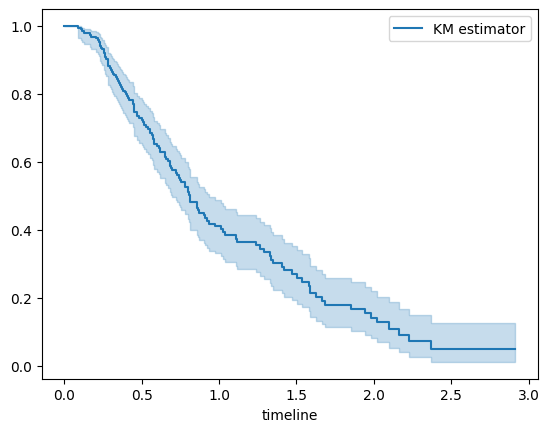

In [206]:
from abess.datasets import make_glm_data
from lifelines import KaplanMeierFitter

# generate data 
n, p, k = 200, 10, 2
data = make_glm_data(n, p, k, family="cox", c = 3)

# survival probability
kmf = KaplanMeierFitter()
kmf.fit(data.y[:,0], data.y[:,1], label="KM estimator", alpha=0.05)
kmf.plot()

Here is Python code for solving the sparse proportional hazards model:

In [207]:
import jax.numpy as jnp
from scope import ScopeSolver

def phazard_objective(params):
    Xbeta = jnp.matmul(data.x, params)
    logsum = jnp.zeros_like(Xbeta)
    for i in range(0,n):
        logsum = logsum.at[i].set(jnp.log(jnp.dot(data.y[:,0] >= data.y[:,0][i], jnp.exp(Xbeta))))
    return jnp.dot(data.y[:,1],logsum)/n-jnp.dot(data.y[:,1], Xbeta)/n


solver = ScopeSolver(p, k)
solver.solve(phazard_objective, jit=True)
zeroindex = np.where(solver.get_result()["params"]==0)

# save the data as data.frame
data_df = pd.DataFrame(np.hstack((data.x,data.y)))
data_df.rename(columns={p:"time",
                        p+1:"event"}, inplace=True)
data_df = data_df.astype({"event":int})                   # all variables
data_df_selected = data_df.drop(columns=zeroindex[0])     # selected variables

#print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("True parameter:", data.coef_, "objective:",phazard_objective(data.coef_))

Estimated parameter: [ 0.          0.          0.         -8.08550624  0.          0.
  0.          0.          4.99768812  0.        ] objective: 1.3102307319641113
True parameter: [ 0.          0.          0.         -7.1593541   0.          0.
  0.          0.          4.36071531  0.        ] objective: 1.3173375


The real variables are selected correctly and the estimated parameters are close to the real values. The following will show a comparison of the fitting results of the CoxPH model before and after variable selection.

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\lifelines\fitters\coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")


<lifelines.CoxPHFitter: fitted with 200 total observations, 75 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 125
   partial log-likelihood = -256.52
         time fit was run = 2023-06-02 06:59:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
0           0.03       1.03       0.10            -0.17             0.23                 0.84                 1.25
1          -0.20       0.82       0.10            -0.40            -0.01                 0.67                 0.99
2           0.06       1.06       0.10            -0.15             0.26                 0.86                 1.30
3          -8.50       0.00       0.67            -9.80            -7.19                 0.00                 0.00
4          -0.10       0.90       0.09            -0.28             0.08                 0.75                 1.08
5          -0.17       0.84       0.11            -0.38             0.04                 0.68                 1.04
6          -0.01       0.99       0.10            -0.21             0.19                 0.81                 1.21
7           0.10       1.11       0.10            -0.09             0.30                 0.91                 1.35
8           5.28     195.60       0.42             4.45             6.10                86.05               444.62
9          -0.06       0.94       0.10            -0.26             0.13                 0.77                 1.14

            cmp to      z      p   -log2(p)
covariate                                  
0             0.00   0.27   0.79       0.35
1             0.00  -2.05   0.04       4.63
2             0.00   0.53   0.59       0.75
3             0.00 -12.77 <0.005     121.63
4             0.00  -1.09   0.28       1.86
5             0.00  -1.58   0.11       3.13
6             0.00  -0.12   0.90       0.15
7             0.00   1.04   0.30       1.74
8             0.00  12.59 <0.005     118.39
9             0.00  -0.64   0.52       0.93
---
Concordance = 0.97
Partial AIC = 533.03
log-likelihood ratio test = 569.49 on 10 df
-log2(p) of ll-ratio test = 382.75

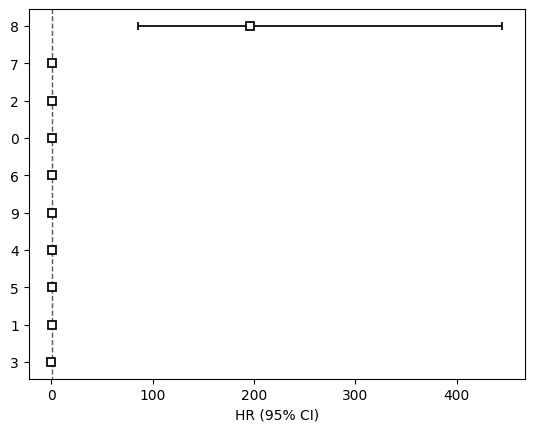

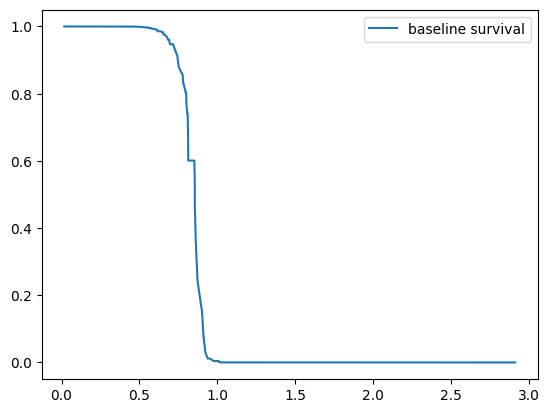

In [208]:
from lifelines import CoxPHFitter

# model fit with all variables
cph = CoxPHFitter()
cph.fit(data_df, duration_col='time', event_col='event')
cph.plot(hazard_ratios=True) 
cph.baseline_survival_.plot()
cph.print_summary()

From the summary table, only true variables with p-values less than 0.05, while the regression coefficients of other variables are around 0 with HR around 1.

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\lifelines\fitters\coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")


<lifelines.CoxPHFitter: fitted with 200 total observations, 75 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 125
   partial log-likelihood = -262.05
         time fit was run = 2023-06-02 07:07:58 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
3          -8.09       0.00       0.63            -9.31            -6.86                 0.00                 0.00
8           5.00     148.07       0.39             4.23             5.77                68.41               320.53

            cmp to      z      p   -log2(p)
covariate                                  
3             0.00 -12.89 <0.005     123.90
8             0.00  12.68 <0.005     120.05
---
Concordance = 0.97
Partial AIC = 528.09
log-likelihood ratio test = 558.43 on 2 df
-log2(p) of ll-ratio test = 402.82

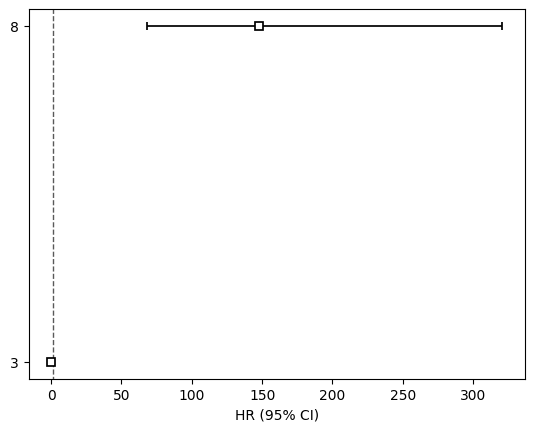

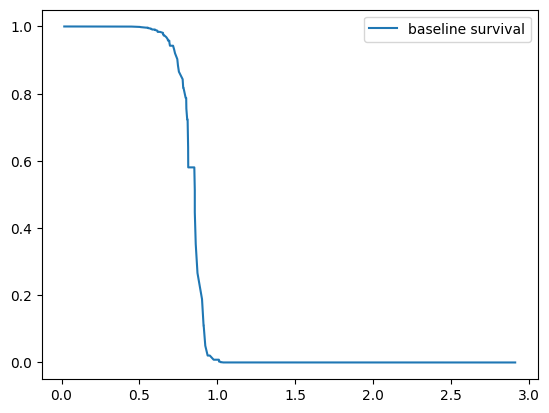

In [210]:
# model fit with selected variables

cph_selected = CoxPHFitter()
cph_selected.fit(data_df_selected, duration_col='time', event_col='event')
cph_selected.plot(hazard_ratios=True) 
cph_selected.baseline_survival_.plot()
cph_selected.print_summary()

All selected variables have significant regression coefficients, and the estimated survival curve is similar to using all variables estimation. The concordance score (also known as the c-index) of the fit, which is a generalization of the ROC AUC to survival data. The concordance scores before and after variable selection are close. Thus, variable selection simplifies the model, also abess selects the true variables.	

.. rubric:: References
.. [1] Cox, D.R. (1972), Regression Models and Life-Tables. Journal of the Royal Statistical Society: Series B (Methodological), 34: 187-202. https://doi.org/10.1111/j.2517-6161.1972.tb00899.x